Reference : https://www.cse.wustl.edu/~garnett/cse515t/fall_2019/files/lecture_notes/8.pdf

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

C:\Users\Inder\AppData\Local\Temp\ipykernel_19844\1826778814.py:20: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(['Class 0'] , ['Class 1'])


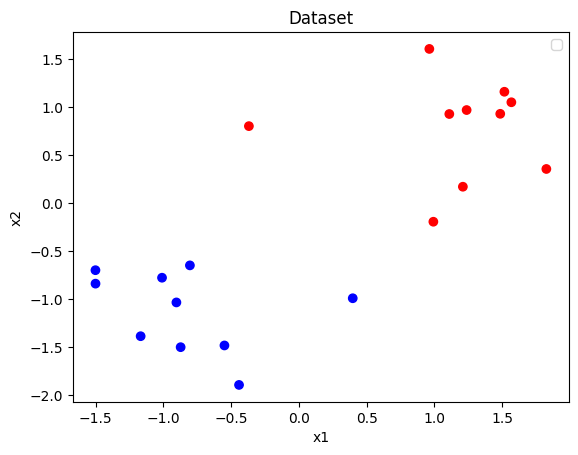

In [68]:
# Dataset
 
dist1 = torch.distributions.MultivariateNormal(torch.tensor([-1., -1.]), torch.eye(2)/4)
dist2 = torch.distributions.MultivariateNormal(torch.tensor([1., 1.]), torch.eye(2)/4)

#Sample 10 points from each distribution
x1 = dist1.sample((10,))
x2 = dist2.sample((10,))
X = torch.cat((x1, x2), 0)

#Create labels for each class
y1 = torch.zeros(10, dtype=torch.long)
y2 = torch.ones(10, dtype=torch.long)
Y = torch.cat((y1, y2), 0)

plt.title('Dataset')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr')
plt.legend(['Class 0'] , ['Class 1'])
plt.show()

In [69]:
# Stack a column of ones to the left of X
X = torch.cat((torch.ones((20, 1)), X), 1)

In [70]:
X = X.reshape(20, 3)
Y = Y.reshape(20, 1)

In [71]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def prior_logprob(mean_prior, cov_prior , theta):
    dist = torch.distributions.MultivariateNormal(mean_prior, cov_prior)
    return dist.log_prob(theta)

def likelihood_logprob(X,Y,theta):
    logprob = torch.tensor(0. , requires_grad=True)
    probs = torch.sigmoid(torch.matmul(X, theta.T))
    for i in range(len(X)):
        logprob = logprob + torch.log(probs[i]) * Y[i] + torch.log(1 - probs[i]) * (1 - Y[i])
    return logprob

# Can do Shape manipulation better 
def unnormalized_posterior_logprob(mean_prior, cov_prior, X,Y,theta):
    return prior_logprob(mean_prior, cov_prior, theta) + likelihood_logprob(X,Y,theta)

In [72]:
theta_mle = torch.tensor([0., 0., 0.], requires_grad=True)
optimizer = torch.optim.Adam([theta_mle], lr=0.01)

for i in range(1000):
    loss = -likelihood_logprob(X,Y,theta_mle)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [73]:
theta_mle

tensor([0.5441, 2.2709, 3.1725], requires_grad=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


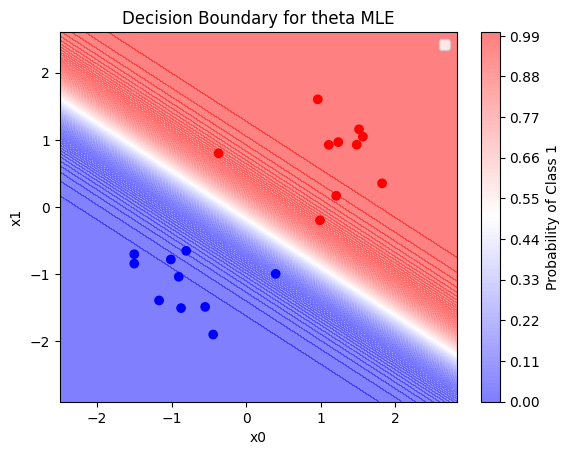

In [74]:
# Plot the decision boundary

min_x0 = torch.min(X[:, 1])
max_x0 = torch.max(X[:, 1])

min_x1 = torch.min(X[:, 2])
max_x1 = torch.max(X[:, 2])

x = torch.linspace(min_x0-1, max_x0+1, 100)
y = torch.linspace(min_x1-1, max_x1+1, 100)

X_mesh, Y_mesh = torch.meshgrid(x, y)
Z = torch.zeros(X_mesh.shape)
for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z[i, j] = torch.sigmoid(torch.dot(theta_mle, torch.tensor([1 , X_mesh[i, j], Y_mesh[i, j]]).T))

X_np = X_mesh.detach().numpy()
Y_np = Y_mesh.detach().numpy()
Z_np = Z.detach().numpy()

plt.contourf(X_np, Y_np, Z_np, cmap='bwr' , levels=100, alpha=0.5)
plt.title('Decision Boundary for theta MLE')
plt.xlabel('x0')
plt.ylabel('x1')
cbar = plt.colorbar()
cbar.set_label('Probability of Class 1')    
plt.legend()
plt.scatter(X[:, 1], X[:, 2], c=Y, cmap='bwr')
plt.show()

In [75]:
mean_prior = torch.tensor([0., 0.,0.])
cov_prior = torch.eye(3)

theta = torch.tensor([0., 0., 0.], requires_grad=True)

In [76]:
optimizer = torch.optim.Adam([theta], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()
    loss = -unnormalized_posterior_logprob(mean_prior, cov_prior,X,Y, theta)
    loss.backward(retain_graph=True)
    optimizer.step()

theta_map = theta

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


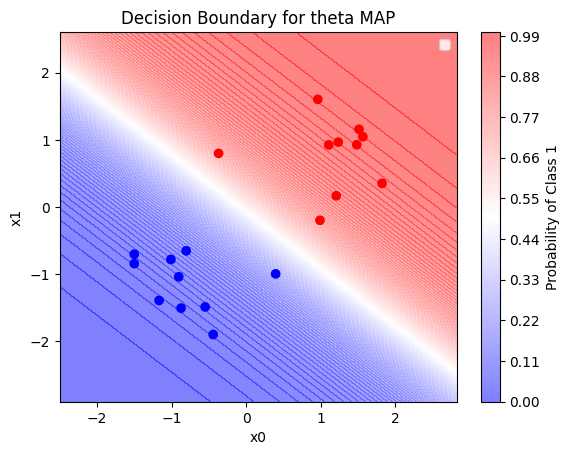

In [77]:
# Plot the decision boundary

min_x0 = torch.min(X[:, 1])
max_x0 = torch.max(X[:, 1])

min_x1 = torch.min(X[:, 2])
max_x1 = torch.max(X[:, 2])

x = torch.linspace(min_x0-1, max_x0+1, 100)
y = torch.linspace(min_x1-1, max_x1+1, 100)

X_mesh, Y_mesh = torch.meshgrid(x, y)
Z = torch.zeros(X_mesh.shape)
for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z[i, j] = torch.sigmoid(torch.dot(theta_map, torch.tensor([1 , X_mesh[i, j], Y_mesh[i, j]]).T))

X_np = X_mesh.detach().numpy()
Y_np = Y_mesh.detach().numpy()
Z_np = Z.detach().numpy()

plt.contourf(X_np, Y_np, Z_np, cmap='bwr' , levels=100, alpha=0.5)
plt.title('Decision Boundary for theta MAP')
plt.xlabel('x0')
plt.ylabel('x1')
cbar = plt.colorbar()
cbar.set_label('Probability of Class 1')    
plt.legend()
plt.scatter(X[:, 1], X[:, 2], c=Y, cmap='bwr')
plt.show()

In [78]:
def neg_hessian_posterior(mean_prior, cov_prior, mode):
    hessian = torch.autograd.functional.hessian(lambda x: -(unnormalized_posterior_logprob(mean_prior, cov_prior, X,Y,x)), mode)
    return hessian

In [79]:
neg_hes = neg_hessian_posterior(mean_prior, cov_prior, theta_map)
print(neg_hes)

tensor([[ 2.5912,  0.1946, -0.3802],
        [ 0.1946,  2.5779,  0.6990],
        [-0.3802,  0.6990,  2.3138]])


In [80]:
inv_neg_hes = torch.inverse(neg_hes)

In [81]:
unnormalized_laplace_approx_posterior = torch.distributions.MultivariateNormal(theta_map, inv_neg_hes)

In [82]:
def predict_prob(x_new , theta_map , inv_neg_hes):
    x_new = x_new.reshape(3, 1)
    var = torch.matmul(torch.matmul(x_new.T, inv_neg_hes), x_new)
    mean = torch.matmul(theta_map, x_new)
    inp = mean / torch.sqrt(1 + var)
    cdf = torch.distributions.Normal(0, 1).cdf(inp)
    return cdf[0].item()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


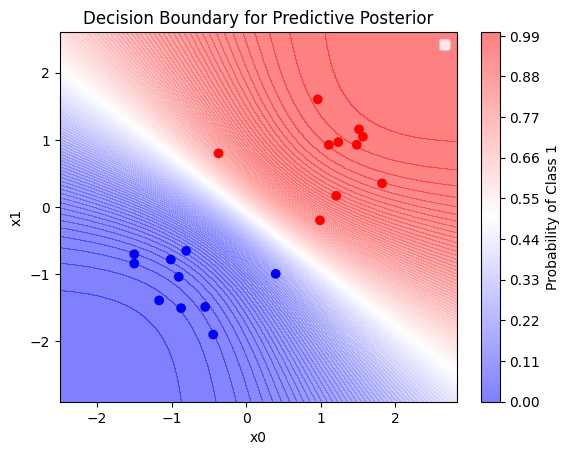

In [83]:
# Plot the decision boundary
min_x0 = torch.min(X[:, 1])
max_x0 = torch.max(X[:, 1])

min_x1 = torch.min(X[:, 2])
max_x1 = torch.max(X[:, 2])

x = torch.linspace(min_x0-1, max_x0+1, 100)
y = torch.linspace(min_x1-1, max_x1+1, 100)

X_mesh, Y_mesh = torch.meshgrid(x, y)
Z = torch.zeros(X_mesh.shape)
for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z[i, j] = predict_prob(torch.tensor([1. , X_mesh[i, j], Y_mesh[i, j]]), theta_map, inv_neg_hes)

X_np = X_mesh.detach().numpy()
Y_np = Y_mesh.detach().numpy()
Z_np = Z.detach().numpy()

plt.contourf(X_np, Y_np, Z_np, cmap='bwr' , levels=100, alpha=0.5)
plt.title('Decision Boundary for Predictive Posterior')
plt.xlabel('x0')
plt.ylabel('x1')
cbar = plt.colorbar()
cbar.set_label('Probability of Class 1')    
plt.legend()
plt.scatter(X[:, 1], X[:, 2], c=Y, cmap='bwr')
plt.show()

Let's try to unlearn

In [84]:
def laplace_logprob(theta):
    # return unnormalized_laplace_approx_posterior.log_prob(theta) - torch.log(torch.tensor(Z_laplace))
    return unnormalized_laplace_approx_posterior.log_prob(theta)

def del_posterior_logprob(theta , x_del , y_del):
    return laplace_logprob(theta) - likelihood_logprob(x_del, y_del, theta) 

In [85]:
# Take the last n points as the del points
n = 5
x_del = X[-n:]
y_del = Y[-n:]

In [86]:
theta_new = torch.tensor([0., 0.,0.], requires_grad=True)

optimizer = torch.optim.Adam([theta_new], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()
    loss = -del_posterior_logprob(theta_new, x_del, y_del)
    loss.backward(retain_graph=True)
    optimizer.step()

theta_del_map = theta_new

In [87]:
neg_hes_del_pos = torch.autograd.functional.hessian(lambda x: -del_posterior_logprob(x, x_del, y_del), theta_del_map)
inverse_neg_hes_del_pos = torch.inverse(neg_hes_del_pos)

In [88]:
print(inverse_neg_hes_del_pos)

tensor([[ 0.7201,  0.2947,  0.1872],
        [ 0.2947,  0.8127, -0.0327],
        [ 0.1872, -0.0327,  0.5627]])


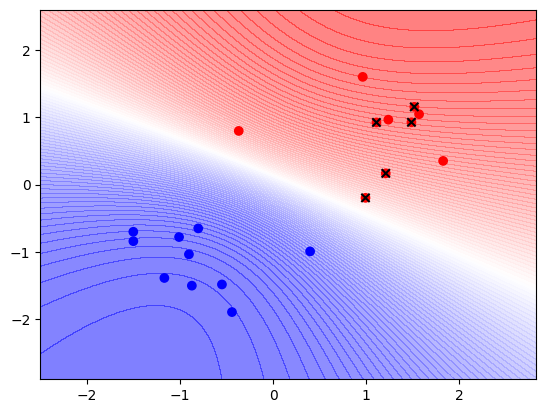

In [89]:
# Plot the decision boundary
min_x0 = torch.min(X[:, 1])
max_x0 = torch.max(X[:, 1])

min_x1 = torch.min(X[:, 2])
max_x1 = torch.max(X[:, 2])

x = torch.linspace(min_x0-1, max_x0+1, 100)
y = torch.linspace(min_x1-1, max_x1+1, 100)

X_mesh, Y_mesh = torch.meshgrid(x, y)
Z = torch.zeros(X_mesh.shape)
for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        Z[i, j] = predict_prob(torch.tensor([1. , X_mesh[i, j], Y_mesh[i, j]]), theta_del_map, inverse_neg_hes_del_pos)

X_np = X_mesh.detach().numpy()
Y_np = Y_mesh.detach().numpy()
Z_np = Z.detach().numpy()

plt.contourf(X_np, Y_np, Z_np, cmap='bwr' , levels=100, alpha=0.5)
plt.scatter(X[:, 1], X[:, 2], c=Y, cmap='bwr')
plt.scatter(x_del[:, 1], x_del[:, 2], c=y_del, cmap='magma' , marker='x')
plt.show()